<a href="https://colab.research.google.com/github/lakshitgosain/Tensorflow-ZTM/blob/main/TF_ZTM_05_TransferLearning_Fine_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with Tensorflow Part 2: Fine Tuning



In [1]:
# Get helper_functions.py script from course GitHub
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py 

# Import helper functions we're going to use
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

--2023-05-31 15:57:46--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-05-31 15:57:47 (85.4 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## Let's get some data

This time we're going to see how we can use the pre-trained models within tf.keras.applications and apply them to our own problem



Get the 10% Foor dataset

In [2]:
import zipfile
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data('10_food_classes_10_percent.zip')

--2023-05-31 16:01:23--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.194.128, 74.125.200.128, 74.125.68.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.194.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  20.0MB/s    in 9.6s    

2023-05-31 16:01:33 (16.8 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ch

In [4]:
# Create training and test direcotry paths

train_dir="10_food_classes_10_percent/train"
test_dir="10_food_classes_10_percent/test"

In [5]:
import tensorflow as tf

IMG_SIZE=(224,224)
BATCH_SIZE=32
train_data_10_percent=tf.keras.preprocessing.image_dataset_from_directory(
    directory=train_dir,
    image_size=IMG_SIZE,
    label_mode='categorical',
    batch_size=BATCH_SIZE,

)

test_data=tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                              image_size=IMG_SIZE,
                                                              label_mode='categorical',
                                                              batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [6]:
train_data_10_percent # NONE is insterted due to the batch sie

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [8]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [12]:
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[2.40000000e+01 1.00000000e+01 9.00000000e+00]
   [2.30918369e+01 1.20918369e+01 1.00918369e+01]
   [2.15663261e+01 1.07806120e+01 8.78061199e+00]
   ...
   [2.24183617e+01 1.64183617e+01 2.64183617e+01]
   [2.49744987e+01 1.89744987e+01 2.89744987e+01]
   [2.41836281e+01 1.81836281e+01 2.81836281e+01]]

  [[2.14285717e+01 1.04285707e+01 8.42857075e+00]
   [1.82142849e+01 7.21428490e+00 5.21428490e+00]
   [1.70561218e+01 6.27040815e+00 4.27040815e+00]
   ...
   [2.29591808e+01 1.49591808e+01 2.59591808e+01]
   [2.62142982e+01 1.82142982e+01 2.92142982e+01]
   [2.53315601e+01 1.73315601e+01 2.83315601e+01]]

  [[1.90663261e+01 8.28061199e+00 6.28061247e+00]
   [1.80561218e+01 7.27040815e+00 5.27040815e+00]
   [2.12142868e+01 1.05969391e+01 8.59693909e+00]
   ...
   [2.81888371e+01 2.04031219e+01 3.07602654e+01]
   [2.51581535e+01 1.73724384e+01 2.77295818e+01]
   [2.71327419e+01 1.93470287e+01 2.97041702e+01]]

  ...

  [[2.54000000e+02 2.54000000e+02 2.54000000e+02]
   [2

Keras Sequential vs FUnctional API

* Functional API is more flexible

## Model 0 : Building a transfer learning feature extraction model with Functional API

The sequential API is straight forward, but the functional API Gives us more flexibility with our models

In [16]:
#1. Create the base model with tf.keras.applications

base_model=tf.keras.applications.EfficientNetB0(
    include_top=False,

)

# 2. Freeze the base model(the underlying pre-trained patterns aren't modified )

base_model.trainable=False

#3. Create the input into our odel
inputs =  tf.keras.layers.Input(shape=(224,224,3), name='Input layer')

#4. If using Resnet50V2 you will need to normalize inputs
#x=tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

#5. pass the inputs to the base_model
x=base_model(inputs)
print(f"shape after passing inputs to our base model{x.shape}")

#6. Average pool the outputs of the base model(aggregate all the most importantinformation)
x=tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)
print(f"shape after global averagepooling2D:{x.shape}")

#7. Create the otput activation layer
outputs=tf.keras.layers.Dense(10, activation='softmax', name='output_layer')(x)

#8 Comibe the inputs with the outputs into a model
model_0=tf.keras.Model(inputs, outputs)

#9 Compile the model
model_0.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)
#10. Fit the model and save it's history
istory_10_percent= model_0.fit(train_data_10_percent,
                               epochs=5,
                               steps_per_epoch=len(train_data_10_percent),
                               validation_data=test_data,
                               validation_steps=int(0.25*len(test_data)),
                               callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                      experiment_name='10_percent')])




shape after passing inputs to our base model(None, 7, 7, 1280)
shape after global averagepooling2D:(None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent/20230531-164213
Epoch 1/5
24/24 [==============================] - 23s 351ms/step - loss: 1.8474 - accuracy: 0.4360 - val_loss: 1.2533 - val_accuracy: 0.7862
Epoch 2/5
24/24 [==============================] - 4s 131ms/step - loss: 1.0792 - accuracy: 0.7907 - val_loss: 0.8236 - val_accuracy: 0.8421
Epoch 3/5
24/24 [==============================] - 5s 199ms/step - loss: 0.7882 - accuracy: 0.8227 - val_loss: 0.6653 - val_accuracy: 0.8734
Epoch 4/5
24/24 [==============================] - 4s 135ms/step - loss: 0.6358 - accuracy: 0.8520 - val_loss: 0.5777 - val_accuracy: 0.8750
Epoch 5/5
24/24 [==============================] - 4s 158ms/step - loss: 0.5460 - accuracy: 0.8707 - val_loss: 0.5390 - val_accuracy: 0.8750


In [17]:
model_0.evaluate(test_data)

79/79 [==============================] - 7s 78ms/step - loss: 0.5511 - accuracy: 0.8636


[0.5510963201522827, 0.8636000156402588]

In [20]:
#Check the layers in out base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer)

0 <keras.engine.input_layer.InputLayer object at 0x7fd440043d90>
1 <keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x7fd4b005d6f0>
2 <keras.layers.preprocessing.normalization.Normalization object at 0x7fd434c877f0>
3 <keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x7fd4b041a560>
4 <keras.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x7fd434852950>
5 <keras.layers.convolutional.conv2d.Conv2D object at 0x7fd434cb8100>
6 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fd434bbf4c0>
7 <keras.layers.core.activation.Activation object at 0x7fd434853280>
8 <keras.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x7fd434889390>
9 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fd434bd54b0>
10 <keras.layers.core.activation.Activation object at 0x7fd434852c20>
11 <keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7fd4348526b0>
12 <keras.l

In [21]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [22]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling_4 (Rescaling)        (None, None, None,   0           ['input_3[0][0]']                
                                3)                                                                
                                                                                                  
 normalization_2 (Normalization  (None, None, None,   7          ['rescaling_4[0][0]']            
 )                              3)                                                   

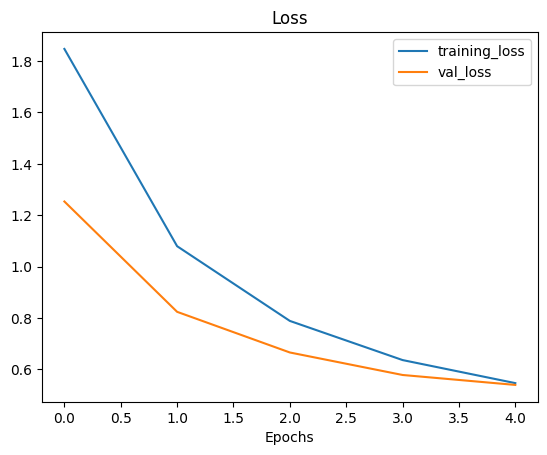

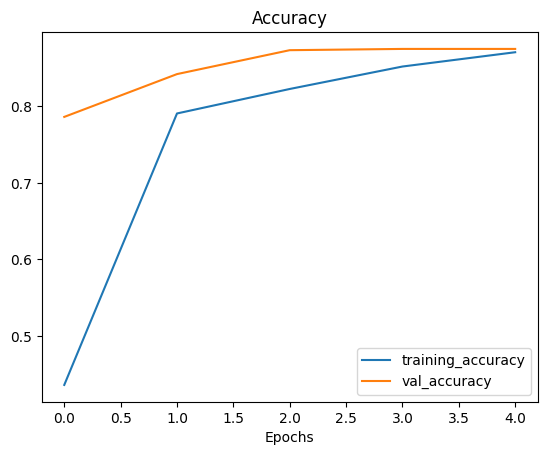

In [24]:
plot_loss_curves(istory_10_percent)